<a href="https://colab.research.google.com/github/BSteiner1/Latent-Augmentation/blob/main/Notebooks/LatentTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import math
import torch.nn.functional as F
import matplotlib.pyplot as plt
from google.colab import files

### Read in the `small_user_item` data

In [2]:
!git clone https://github.com/BSteiner1/Latent-Augmentation

Cloning into 'Latent-Augmentation'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 15 (delta 2), reused 12 (delta 2), pack-reused 0
Receiving objects: 100% (15/15), 865.32 KiB | 4.30 MiB/s, done.
Resolving deltas: 100% (2/2), done.


In [3]:
%cd Latent-Augmentation/Data

/content/Latent-Augmentation/Data


In [4]:
path = 'small_user_item.csv'

In [5]:
df = pd.read_csv(path)

# Convert column headers from string to integer
df.columns = df.columns.astype(int)
# Sort the DataFrame based on column headers
df = df.sort_index(axis=1)

num_movies = len(df.columns)

### Split the data into train and test

In [6]:
def train_test_split(dataframe, frac):

    # get a random sample
    test = df.sample(frac=frac, axis=0)

    # get everything but the test sample
    train = df.drop(index=test.index)

    return train, test

### Convert the data into a tensor

In [7]:
def frameToTensor(data):
    # To NumPy array
    data = data.values
    # To PyTorch tensor
    data = torch.tensor(data, dtype=torch.float32)

    return data

### Create a Dataloader

In [8]:
def convertToDataloader(tensor_data, batch_size):

  train_loader = Data.DataLoader(tensor_data, batch_size=batch_size, shuffle=True)

  return train_loader

### A function to calculate model accuracy

In [9]:
def Evaluation(model, test_data):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for i in range(len(test_data)):
            input = test_data[i]
            # Output predicted ratings
            output = model(input)
            # Mask the missing values from the input in the output
            output[input == 0] = 0
            loss = F.mse_loss(input, output)
            total_loss += loss.item()

    return total_loss


### A function to reset the weights of the network

In [10]:
def reset_parameters(module):
    if isinstance(module, nn.Linear):
        module.reset_parameters()

### Define the model architecture

In [11]:
latent_space_size = 20

In [12]:
layers = [
    nn.Linear(num_movies, 200), nn.Dropout(0.2),
    nn.Sigmoid(),
    nn.Linear(200, 50), nn.Dropout(0.2),
    nn.Sigmoid(),
    nn.Linear(50, latent_space_size), nn.Dropout(0.2),
    nn.Sigmoid(),
    nn.Linear(latent_space_size, 50), nn.Dropout(0.2),
    nn.Sigmoid(),
    nn.Linear(50, 200), nn.Dropout(0.2),
    nn.Sigmoid(),
    nn.Linear(200, num_movies)
]

In [13]:
autoencoder = nn.Sequential(*layers)

# Define the optimizer and associate it with the model parameters
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [14]:
# The layer corresponding to the latent space
latent_layer = 9

### Extract the latent features

In [15]:
def getLatentFeatures(data, model, c):
    # Set the model to evaluation mode
    autoencoder.eval()

    # Define the size of the latent features
    latent_dim = latent_space_size

    # Create an empty tensor to store the latent features
    latent_features = torch.empty(len(data), latent_dim)

    # Extract the latent features and store in the tensor
    # Index 5 gives the FC layer of size 10
    for i, input in enumerate(data):
      with torch.no_grad():
          latent = model[:latent_layer](input)
          latent_features[i] = latent.squeeze().detach()

    # Subsample a fraction c of the latent features to use
    length = latent_features.size(0)
    sample_size = int(length*c)
    #print(sample_size)
    sampled_indices = torch.randperm(length)[:sample_size]
    latent_features = latent_features[sampled_indices]

    return latent_features

### Add noise to the latent features

In [16]:
def addNoise(latent_features, std_dev, frac):

  noisy_latent_features = []

  shape = (latent_space_size)  # Shape of the desired tensor
  fraction_of_zeros = frac  # Fraction of zeros in the tensor

  # AddGaussian noise to some of the latent features
  for i in range(len(latent_features)):
    random_tensor = torch.rand(shape)
    random_tensor = (random_tensor >= fraction_of_zeros).int()
    noisy_features = latent_features[i] + (random_tensor * torch.rand(shape) * std_dev)
    noisy_latent_features.append(noisy_features)

  noisy_latent_features = torch.stack(noisy_latent_features)

  return noisy_latent_features

### Decode the noisy latent features

In [17]:
def decodeNoisyFeatues(noisy_latent_features):

  decoded_noisy_latent_features = []

  # Decode the noisy features
  with torch.no_grad():
    for i in range(noisy_latent_features.shape[0]):
        x = noisy_latent_features[i]
        decoded = autoencoder[latent_layer:](x)

        #random_indices = np.random.choice(9724, 9561, replace=False)
        #decoded[random_indices] = 0

        decoded_noisy_latent_features.append(decoded)

  decoded_noisy_latent_features = torch.stack(decoded_noisy_latent_features)

  return decoded_noisy_latent_features

### Calculate the batch-size required for the augmented dataset

In [18]:
def augmentBatchSize(batch_size, c, n):

  # Calculate the required augmented batch size
  augmented_batch_size = math.ceil(((1+c)*n)/math.ceil(n/batch_size))

  return augmented_batch_size

### Training Loop

In [19]:
num_epochs = 50

In [20]:
def Loop(autoencoder, train_loader, test_data):

  test_loss = []

  # Apply reset_parameters to parameterized layers in the model
  for layer in autoencoder:
      reset_parameters(layer)

  # Training the autoencoder
  for epoch in range(1, num_epochs + 1):
    train_loss = 0
    s = 0.

    # Iterate over mini-batches
    for batch_idx, batch_data in enumerate(train_loader):
        inputs = Variable(batch_data)
        targets = inputs.clone()

        if torch.sum(targets.data > 0) > 0:
            outputs = autoencoder(inputs)
            targets.requires_grad = False
            # Mask missing values
            outputs[targets == 0] = 0
            loss = criterion(outputs, targets)

            # Back propagation step
            autoencoder.zero_grad()
            loss.backward()
            optimizer.step()

            # Accumulate the loss for the batch
            train_loss += np.sqrt(loss.data) * len(inputs)
            s += len(inputs)

    # Compute average loss for the epoch
    avg_loss = train_loss / s
    test_loss.append(Evaluation(autoencoder, test_data))
    #print('epoch: ' + str(epoch) + ' loss: ' + str(avg_loss))

  return test_loss

    #if epoch == 10:
  #return Evaluation(autoencoder, test_data)

### Define some hyperparameters

In [21]:
batch_size = 16
# How much to augment the dataset by
c = 0.1
# Std. Dev. of the noise
std_dev = 0.1
# Fraction of features to add noise to
frac_noisy = 0.5

### The entire training process

In [22]:
scores = []
aug_scores = []

for i in range(3):

  print(i+1)

  # Train and test sets
  training_df, test_df = train_test_split(df, 0.2)
  # A training validation set to measure overfitness
  train_val_df = df.sample(len(test_df))

  train_data = frameToTensor(training_df)
  test_data = frameToTensor(test_df)
  train_val_data = frameToTensor(train_val_df)

  train_loader = convertToDataloader(train_data, batch_size)

  # Train and evaluate autoencoder
  score = Loop(autoencoder, train_loader, test_data)
  print("AE test loss:", score)
  print("AE train loss:", Evaluation(autoencoder, train_val_data))
  scores.append(score)

  # Data augmentation
  n = len(train_data)
  # Define data augmentation size
  latent_features = getLatentFeatures(train_data, autoencoder, c)
  # Add noise to the latent features
  noisy_latent_features = addNoise(latent_features, std_dev, frac_noisy)
  decoded_noisy_features = decodeNoisyFeatues(noisy_latent_features)
  augmented_data = torch.cat((train_data, decoded_noisy_features), dim=0)

  augmented_batch_size = augmentBatchSize(batch_size, c, n)
  augmented_loader = convertToDataloader(augmented_data, augmented_batch_size)

  # Train and evaluate augmented dataset model
  aug_score = Loop(autoencoder, augmented_loader, test_data)
  print("Augmented test loss:", aug_score)
  print("Augmented train loss:", Evaluation(autoencoder, train_val_data))
  aug_scores.append(aug_score)



print(scores)
print(aug_scores)

1
AE test loss: [5.713249204563908, 3.384001712198369, 3.107387338881381, 3.027471672568936, 3.0142285104375333, 3.0147388192126527, 3.0216218594578095, 3.031527499493677, 3.0126148173585534, 2.999384701193776, 3.031039803638123, 3.022158423671499, 3.0131120171863586, 3.050003043259494, 3.023394981981255, 3.0219495269702747, 3.0166446523508057, 3.0068583807442337, 2.990899792406708, 2.9997869682265446, 2.9994464113842696, 2.982608424150385, 3.019704288977664, 2.9896771172061563, 3.0022789512295276, 3.0027966756606475, 2.9942440579179674, 2.9980240949662402, 3.010599907953292, 3.0223891477799043, 2.9937187031609938, 2.9948641834780574, 2.993407150148414, 3.00961111264769, 2.9933379809372127, 2.9944779970683157, 3.0010413182899356, 3.0120220934040844, 3.0021339763188735, 2.998498959816061, 3.0050238231197, 3.0013147791614756, 2.991723389015533, 3.0012739570229314, 3.000008361879736, 2.9843559205764905, 2.9839438744820654, 2.9848610141780227, 2.993139282334596, 3.003997922874987]
AE train

### A plot to visualise the learning process

In [23]:
# Element-wise average of the simulations
reg_element_wise_avg = [sum(elements) / 3 for elements in zip(*scores)]
aug_element_wise_avg = [sum(elements) / 3 for elements in zip(*aug_scores)]

In [24]:
# Slice the data to only view the start
slice_idx = 30

In [25]:
reg_element_wise_avg = reg_element_wise_avg[:slice_idx]
aug_element_wise_avg = aug_element_wise_avg[:slice_idx]

In [26]:
epochs = [i for i in range(1, slice_idx+1)]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

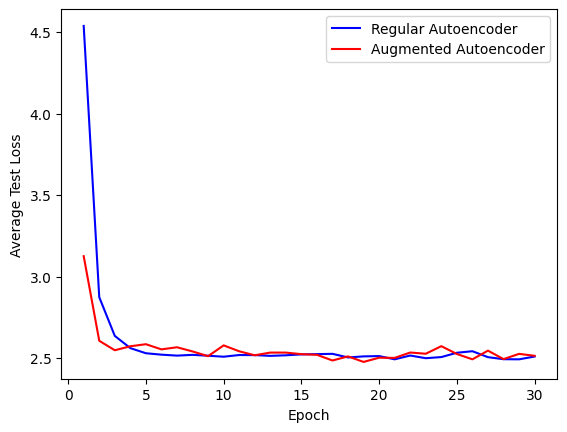

In [27]:
# Create the line plot with different colors
plt.plot(epochs, reg_element_wise_avg, color='blue', label='Regular Autoencoder')
plt.plot(epochs, aug_element_wise_avg, color='red', label='Augmented Autoencoder')

# Add labels and legend
plt.xlabel('Epoch')
plt.ylabel('Average Test Loss')
plt.legend()

plt.savefig('LearningPlot.png')
files.download('LearningPlot.png')

# Show the plot
plt.show()

### Compare performance

In [28]:
avg_reg_last_entry = sum(sublist[-1] for sublist in scores) / len(scores)
print(avg_reg_last_entry)

2.5035763620592966


In [29]:
avg_aug_last_entry = sum(sublist[-1] for sublist in aug_scores) / len(aug_scores)
print(avg_aug_last_entry)

2.5056536672539855
